# Here I provide a general description of the correction algorithm

## Main objectives:
-> population_histsoc_0p5deg_annual_1861-2005.nc4 and population_ssp2soc_0p5deg_annual_2006-2100.nc4 should become spatially consistent, meaning that there is no discontinuity at any gridcell during the transition between year 2005 and 2006 between the two datasets

-> population_ssp2soc_0p5deg_annual_2006 should maintain consistency with its initial national population, meaning that despite the potential correction to individual gridcell timeseries, when aggregated at country level, the uncorrected and corrected dataset should provide the same total country population.

## Methodology:
To achieve the formulated objectives, the following steps are required:

1) Extract the last year of the population_histsoc_0p5deg_annual_1861-2005.nc4 dataset (year 2005)
2) Assign each gridcell in the file (1) to its corresponding country 
3) For each country, sum over the corresponding gridcells from (2) file to obtain for each country the total population based on contribution from each gridcell assigned to the given country
4) Divide each gridcell value from file (2) by total population for the corresponding country obtained in (3); this way we will obtain the proportion with which a given gridcell is contributing to the entire country population; e.g. a value of 0.1 means that this gridcell contains 10% of the total country population (likely a big city)

Now we can begin to correct the population_ssp2soc_0p5deg_annual_2006-2100.nc4 dataset using spatial downscalling coeffiencients obtained in (4). To do so we should do the following:

5) For a given year (loop from 2006 till 2100 included) calculate for each country the total population in the dataset we try to correct.
6) The corrected dataset is obtained as the sum of two terms: [multiply the spatial downscalling coefficients obtained in (4) with the values of total country population obtained in (5)] + [the originial gridcells populations in regions outside regionamsk supported countries (to cover small insular countries population and avoid loss of information)]
7) Save the corrected data as ../corrected/corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc4

In [1]:
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import h5netcdf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import NaturalEarthFeature
from matplotlib import colors
from functools import reduce

ModuleNotFoundError: No module named 'h5netcdf'

In [3]:
# Define the regions over which future masking will be applied
# In our case we are interested in country level aggregation
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries.plot(add_label=False)

<GeoAxesSubplot:>

## Potential issue:
As we can see from the map despite covering all big countries (total of 177 countries), currently regionmask does not represent well the small insular countries.
This limitation will be taken into account in the correction process to avoid discrepancies in total world population between corrected and uncorrected datasets. 

In [4]:
# Extract the year 2005 data from the reference population_histsoc_0p5deg_annual_1861-2005.nc4
# We want to achieve spatial consistency with this dataset for all future years in the scenarios data
ref_pop_2005 = xr.open_dataset("../data/population_histsoc_0p5deg_annual_1861-2005.nc4", engine='h5netcdf', decode_times=False).number_of_people[144,:,:]

# Load the scenario population dataset we want to correct:
pop_future = xr.open_dataset("../data/population_ssp2soc_0p5deg_annual_2006-2100.nc4", engine='h5netcdf', decode_times=False).number_of_people[:,:,:]

# Generate a mask object for each country based on the grid of our input data
# This will result in an object that for a given country will have all corresponding gridcells filled with the country index value
# For example for US all corresponding gridcells will be filled with "4"
# All gridcells which are not part of any country will be filled with NaN
mask = countries.mask(ref_pop_2005).fillna(999) # we fillna values with a custom key "999" because some of these points not identified as countries due to limits of regionmask, actually contain small populated insular country and using this key we can still have access to these points

# Obtain a list of all countries names and index:
countries_names = countries.names
countries_index = countries.numbers

# Get number of years in the future dataset to loop over
years = pop_future.shape[0]

# Destination to save file:
destination = "../corrected/"

# Name of corrected dataset:
file_name = "corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc"


ValueError: unrecognized engine h5netcdf must be one of: ['netcdf4', 'scipy', 'store']

In [ ]:
# Prepare the correction indices
# The meaning of this dataset for a given country is: what fraction of the given country total population is located in a given gridcell
# For example if we mask for US (index 4), and we find that one gridcell in correction_indices for US contains the value 0.05,
# it means that this gridcell contains 5% of total US population
# If we want to obtain spatially consistent data at the transition between 2005 and 2006, it means that for each country, these fraction coefficients should stay the same during the transition and for future years
correction_indices = ref_pop_2005.copy(deep = True)*0.0 # initialize each gridcell with dummy data (zeros)

# Loop over each country
for country in range(countries_index[-1]+1):
    # Calculate country total population
    country_total_population_ref = ref_pop_2005.where(mask == country).sum()

    # Compute what is the fraction of contribution of each country gridcell to its total population for the reference year 2005
    correction_indices = correction_indices + (ref_pop_2005.where(mask == country)/country_total_population_ref).fillna(0) # fillna(0) used to avoid summation with NaN values which would occur because using masking for second term of the summation

    # Perform a series of tests to detect potential issues:
    # In principle we expect the sum over all fractions to return 1
    # If it returns 0, it means that the algorithm detected no population
    # After runing the script we find that 0.0 is returned only for Fr. S. Antarctic Lands and Antarctica (which make sense)
    # For all remaining countries, sum over all fractions equal 1 
    if np.nansum(correction_indices.where(mask==country).values) == 0.0:
        print("Attention: the sum over all contribution coefficients is 0.0, meaning that there is no population.")
        print("This happens for the country: " + str(countries_names[country]))
        print("Country index is: " + str(country))
        print("If this does not make sense for this country, please check the code!")
        print("For assistance, if needed, please contact sabin.taranu@vub.be.")
    if (np.abs(np.nansum(correction_indices.where(mask==country).values) - 1) > 10e-6) and (np.nansum(correction_indices.where(mask==country).values) != 0.0): # acceptable numerical error limit 10e-6
        print("ERROR: the sum over all contribution coefficients do not add to 1.0")
        print("Problem for the country: " + str(countries_names[country]))
        print("Country index is: " + str(country))
        print("Coefficients sum is: " + str(np.nansum(correction_indices.where(mask==country).values)))
        print("For assistance, if needed, please contact sabin.taranu@vub.be.")
        break


In [ ]:
corrected_data = pop_future.copy(deep=True)*0.0 # prepare array to store corrected data for each year in the scenario dataset (initialize with dummy values - zeros)
array_ones = ref_pop_2005.copy(deep = True)*0.0+1.0 # xarray of ones with same shape as ref_pop_2005; we will use this array for basic operations in the following 

# Loop over all future years:
for year in range(years):
    # previously we introduced the mask object, which had a given index value in each gridcell identified to be part of a given country
    # we now want to create a similar mask object, but instead of corresponding index value, it will have total country population in each gridcell of given country
    # we will use this array, together with correction indices to perform spatial downscalling of future countries populations with consistent spatial distribution with year 2005 of the ref dataset
    mask_with_total_countries_population = ref_pop_2005.copy(deep=True)*0.0 # initialize with dummy data (zeros)
    # Loop over each country
    for country in range(countries_index[-1]+1):
        # Calculate country total population for given year
        country_total_population_given_year = pop_future[year].where(mask == country).sum()
        # Save total country population value in each gridcell corresponding to this country
        mask_with_total_countries_population = mask_with_total_countries_population + (array_ones.where(mask == country)*country_total_population_given_year).fillna(0)
        
        if (country != 23 and country !=159): # if coutry different from Fr. S. Antarctic Lands and Antarctica where population is 0
            # Check if total countries population was saved correctly in each gridcell corresponding to that country
            # We do this by: [[sum over all grid points in mask_with_total_countries_population corresponding to given country]/[number of grid points part of given country]]/[country total population for given year obtained from scenario dataset] - 1 
            # If the procedure was performed correctly this operation should give 0 within certain numerical error (here acceptable limit 10e-6)  
            if np.abs(np.nansum(mask_with_total_countries_population.where(mask==country).values)/np.nansum(np.isnan(mask_with_total_countries_population.where(mask==country).values) == False)/country_total_population_given_year - 1) > 10e-6:
                print("ERROR: it seems that country total population was not saved correctly in each gridcell.")
                print("This will cause incorect downscaling.")
                print("Please check the code for potential issues.")
                print("The error message concerns: " + str)
                print("For assistance, if required, please contact sabin.taranu@vub.be")

        
    # Here we assemble the gridded corrected population data for given year as the sum of downscaled total countries population for given year (correction achieved for 177 countries) and non-corrected population over insular countries
    # The population over insular countries in general do not require spatial correction, as their spatial scale is very small.  
    corrected_data[year] = corrected_data[year] + mask_with_total_countries_population*correction_indices + pop_future[year].where(mask == 999).fillna(0)
    # Return 0 population values into NaNs:
    corrected_data[year] = corrected_data[year].where(corrected_data[year] != 0)

In [ ]:
# Save the corrected data
corrected_data.to_netcdf(path = destination+file_name)

# Visualize the problem as well as added value of the solution:
In the following we perform some basic plots of population data at the transion between year 2005 and 2006.
While spatial inconsistencies can already be seen with naked eye on the global maps between year 2005 and 2006 for original data, we also add two regionals maps (Australia and Northern Africa) with black boxes around regions with prominent spatial discrepancies.

The reader can also notice that these spatial inconsistencies disapeared in the corrected verision of population data for year 2006.
In the following we will provide a more complete validation of our correction strategy.

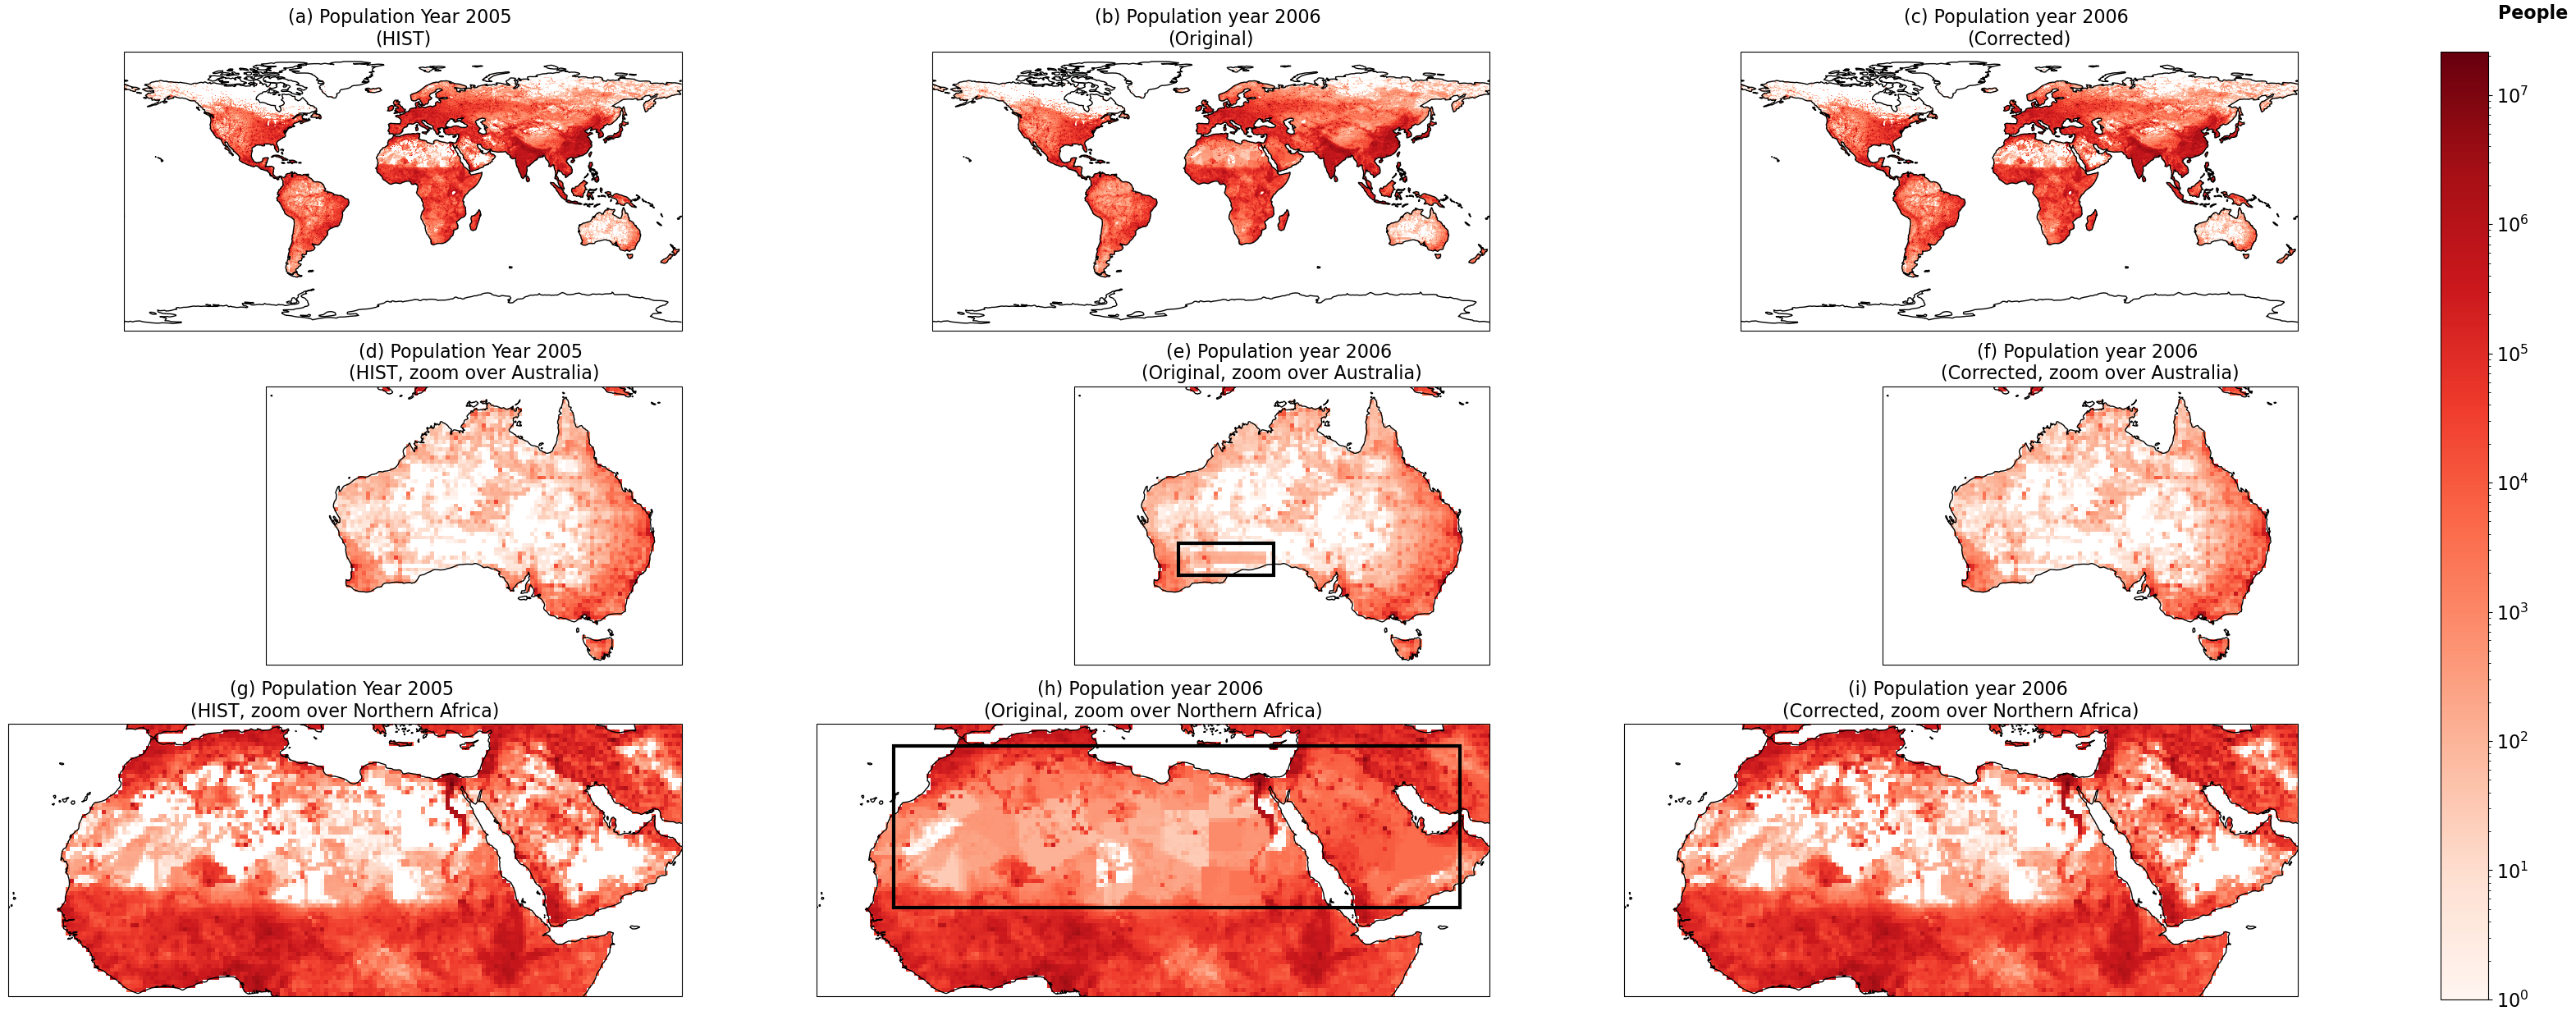

In [104]:
import matplotlib.patches as patches

hist_pop_2005 = xr.open_dataset("../population_histsoc_0p5deg_annual_1861-2005.nc4", engine='h5netcdf', decode_times=False).number_of_people[144,:,:]
original_pop_2006 = xr.open_dataset("../population_ssp2soc_0p5deg_annual_2006-2100.nc4", engine='h5netcdf', decode_times=False).number_of_people[0,:,:]
corrected_pop_2006 = xr.open_dataset("../corrected/corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc", engine='h5netcdf', decode_times=False).number_of_people[0,:,:]


mask_all_countries = (np.isnan(countries.mask(hist_pop_2005)) == False)

lon = hist_pop_2005.lon
lat = hist_pop_2005.lat

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree()
# Prepare colormap
cmap = plt.cm.Reds

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(15*3, 5*3), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

for ax in axlist:
    ax.coastlines()



map1 = axlist[0].pcolormesh(lon, lat, hist_pop_2005.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[0].set_title('(a) Population Year 2005 \n(HIST)', fontsize=16)

map2 = axlist[1].pcolormesh(lon, lat, original_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[1].set_title('(b) Population year 2006 \n(Original)', fontsize=16)

map3 = axlist[2].pcolormesh(lon, lat, corrected_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[2].set_title('(c) Population year 2006 \n(Corrected)', fontsize=16)


map4 = axlist[3].pcolormesh(lon, lat, hist_pop_2005.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[3].set_extent([105, 157, -44.2, -9.3], crs=data_crs)
axlist[3].set_title('(d) Population Year 2005 \n(HIST, zoom over Australia)', fontsize=16)

map5 = axlist[4].pcolormesh(lon, lat, original_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[4].set_extent([105, 157, -44.2, -9.3], crs=data_crs)
axlist[4].set_title('(e) Population year 2006 \n(Original, zoom over Australia)', fontsize=16)

map6 = axlist[5].pcolormesh(lon, lat, corrected_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[5].set_extent([105, 157, -44.2, -9.3], crs=data_crs)
axlist[5].set_title('(f) Population year 2006 \n(Corrected, zoom over Australia)', fontsize=16)


map7 = axlist[6].pcolormesh(lon, lat, hist_pop_2005.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[6].set_extent([-23.6, 59.7, 4, 37.7], crs=data_crs)
axlist[6].set_title('(g) Population Year 2005 \n(HIST, zoom over Northern Africa)', fontsize=16)

map8 = axlist[7].pcolormesh(lon, lat, original_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[7].set_extent([-23.6, 59.7, 4, 37.7], crs=data_crs)
axlist[7].set_title('(h) Population year 2006 \n(Original, zoom over Northern Africa)', fontsize=16)

map9 = axlist[8].pcolormesh(lon, lat, corrected_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[8].set_extent([-23.6, 59.7, 4, 37.7], crs=data_crs)
axlist[8].set_title('(i) Population year 2006 \n(Corrected, zoom over Northern Africa)', fontsize=16)

#plt.subplots_adjust(wspace=0.05, hspace=0.15)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)

axlist[4].add_patch(patches.Rectangle(
        #xy=(20, 15),  # point of origin.
       xy=(118, -33),
       width=12, height=4, linewidth=3,
       color='black', fill=False))

axlist[7].add_patch(patches.Rectangle(
       xy=(-14, 15),  # point of origin.
       #xy=(118, -33),
       width=70, height=20, linewidth=3,
       color='black', fill=False))

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical')
cb.set_label('People', size=16, weight='bold', rotation=0, y=1.05)
cb.ax.tick_params(labelsize=16)


## Validation section
### Objective 1 was:  

-> population_histsoc_0p5deg_annual_1861-2005.nc4 and population_ssp2soc_0p5deg_annual_2006-2100.nc4 should become spatially consistent, 
meaning that there is no discontinuity at any gridcell during the transition between year 2005 and 2006 between the two datasets

To test this the following metric is proposed:
1) We compute the absolute difference between each gridcell of population_ssp2soc_0p5deg_annual_2006-2100.nc4 vs population_histsoc_0p5deg_annual_1861-2005.nc4 datasets
2) We aggregate these differences at the level of each country
3) If data would be spatially consistent, the sum of absolute difference for a given country will be equal to the absolute change in total given country population between year 2005 and 2006. But if the data would be spatially inconsistent, the aggregated sum of absolute gridcells diferences over given country will be larger than corresponding absolute change in total population due to additional difference term caused by different spatial distribution of population. 
4) By visualizing for each country the aggregated sum of absolute gridcells differences vs absolute change in total population we should obtain a perfect correlation for the  
population_histsoc_0p5deg_annual_1861-2005.nc4 and the corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc datasets; and not perfect correlation for not-corrected population_ssp2soc_0p5deg_annual_2006-2100.nc4 for the transition years 2005 and 2006.
5) In principle the same logic can be applied for remaining years.


In [24]:
# Here we implement visualization of metric 1
metric_1_before_correction = [] # array to store for a given country sum over all absolute gridcell population differences between year 2005 and 2006 before correction
metric_1_after_correction  = [] # array to store for a given country sum over all absolute gridcell population differences between year 2005 and 2006 after correction
metric_1_absolute_population_change_before_correction = [] # array to store country absolute population change between year 2005 and 2006 before correction
metric_1_absolute_population_change_after_correction  = [] # array to store country absolute population change between year 2005 and 2006 after correction
year = 0 # corresponds here to year 2006 in pop_future
for country in range(countries_index[-1]+1):
    metric_1_before_correction.append(np.nansum(np.abs(ref_pop_2005.where(mask == country) - pop_future[year].where(mask == country))))
    metric_1_after_correction.append(np.nansum(np.abs(ref_pop_2005.where(mask == country) - corrected_data[year].where(mask == country))))

    metric_1_absolute_population_change_before_correction.append(np.abs(np.nansum(ref_pop_2005.where(mask == country)) - np.nansum(pop_future[year].where(mask == country))))
    metric_1_absolute_population_change_after_correction.append(np.abs(np.nansum(ref_pop_2005.where(mask == country)) - np.nansum(corrected_data[year].where(mask == country))))

    # Check if absolute change in total country population consistent between uncorrected and corrected datasets
    if (country != 23 and country !=159): # if coutry different from Fr. S. Antarctic Lands and Antarctica where population is 0
        if np.abs(metric_1_absolute_population_change_before_correction[-1] - metric_1_absolute_population_change_after_correction[-1])/np.abs(metric_1_absolute_population_change_before_correction[-1]) > 0.001: # acceptable numerical relative error of 0.1%
            print("ERROR: There is an inconsistency in the absolute change of total country population between year 2005 and 2006")
            print("Error is happening for country: " + str(countries_names[country]))
            print("Check the code for potential issues or contact sabin.taranu@vub.be for support.")
            print("Relative error of: " + str((np.abs(metric_1_absolute_population_change_before_correction[-1] - metric_1_absolute_population_change_after_correction[-1])/np.abs(metric_1_absolute_population_change_before_correction[-1]))*100) + "%")
            print("For any assistance, if required, please contact sabin.taranu@vub.be")
            break


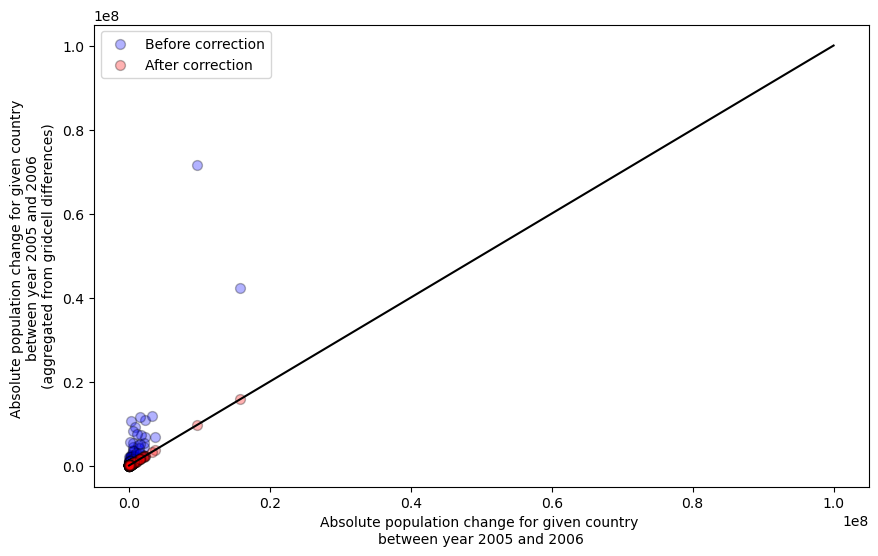

In [116]:
# Here we implement visualization of metric 1
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.scatter(x = metric_1_absolute_population_change_before_correction, y = metric_1_before_correction, s=50, alpha=0.3, c = 'b', edgecolors="k", label="Before correction")
ax.scatter(x = metric_1_absolute_population_change_after_correction, y = metric_1_after_correction, s=50, alpha=0.3, c = 'r', edgecolors="k", label="After correction")

ax.set_xlabel("Absolute population change for given country \nbetween year 2005 and 2006")
ax.set_ylabel("Absolute population change for given country \nbetween year 2005 and 2006 \n(aggregated from gridcell differences)")


# Create sequence of 1000 numbers from 0 to 100 to max absolute population change
xseq = np.linspace(0, 10*10e6, num=1000)
ax.plot(xseq, xseq, 'k')

ax.legend()

## Validation section:
### Objective 2 was:
-> population_ssp2soc_0p5deg_annual_2006 should maintain consistency with its initial national population, meaning that despite the potential correction to individual gridcell timeseries, when aggregated at country level, the uncorrected and corrected dataset should provide the same total country population.

We actually already checked for this during the correction algorithm and in Objective 1 validation.
So here we propose to just test if global population is consistent between corrected and original datasets.

In [110]:
# Here we implement visualization of metric 2 (global population)
years_array =  np.linspace(1861, 2100, num=(2100-1861 + 1))

hist_data = xr.open_dataset("../population_histsoc_0p5deg_annual_1861-2005.nc4", engine='h5netcdf', decode_times=False).number_of_people[:,:,:]
original_scenario_data = xr.open_dataset("../population_ssp2soc_0p5deg_annual_2006-2100.nc4", engine='h5netcdf', decode_times=False).number_of_people[:,:,:]
corrected_scenario_data = xr.open_dataset("../corrected/corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc", engine='h5netcdf', decode_times=False).number_of_people[:,:,:]

original_global_population = []
corrected_global_population = []

for year in range(int(years_array[-1]-1861)+1):

    if year < 145:
        original_global_population.append(np.nansum(hist_data[year]))
        corrected_global_population.append(np.nansum(hist_data[year]))
    else:
        original_global_population.append(np.nansum(original_scenario_data[year-145]))
        corrected_global_population.append(np.nansum(corrected_scenario_data[year-145]))
    

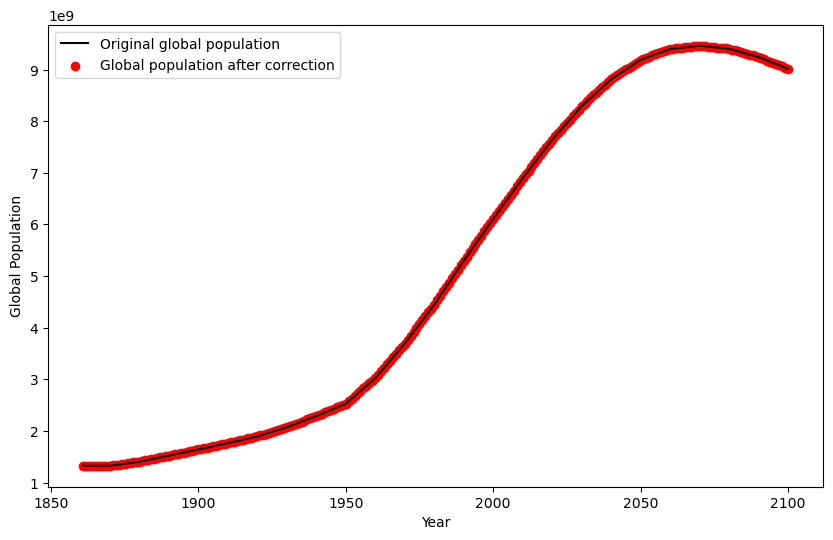

In [117]:
# Here we implement visualization of metric 2 (global population)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(years_array, original_global_population, c='k', label="Original global population")
ax.scatter(years_array, corrected_global_population, c='r', label="Global population after correction")

ax.set_xlabel("Year")
ax.set_ylabel("Global Population")

ax.legend()